In [43]:
from edahelper import *
import sklearn.naive_bayes as NB
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
# Resources:

#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


In [2]:
wsb = pd.read_csv('../Data/wsb_cleaned.csv')

In [3]:
#set up appropriate subset, removing comment outliers
#also chose to look at only self posts
dfog=wsb.loc[(wsb.is_self==True) & (wsb.ups>=10) & (wsb.num_comments<=10000) & ~(wsb["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False))]

 ## Preprocessing
 
 Removing characters that are not alphanumeric or spaces:

In [4]:
def RegexCols(df,cols):
    newdf=df
    regex = re.compile('[^a-zA-Z ]')
    for col in cols:
        newdf=newdf.assign(**{col: df.loc[:,col].apply(lambda x : regex.sub('', str(x) ))})
    return newdf
df=RegexCols(dfog,['title', 'author', 'selftext'])
#df=pd.DataFrame()
#regex = re.compile('[^a-zA-Z ]')
#for col in ['title', 'author', 'selftext']:
#    df.loc[:,col] = dfog.loc[:,col].apply(lambda x : regex.sub('', str(x) ))

Filtering the data frame, count vectorizing titles.

# Can we predict the number of upvotes using the self text?

In [5]:
#create the train test split
#try to predict ups using the self text
X_train, X_test, y_train, y_test = train_test_split(df['selftext'], df['ups'], test_size=0.2, random_state=46)

#make a pipeline to do bag of words and linear regression
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression(copy_X=True)),
])

In [6]:
text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=Fa

In [7]:
#text_clf.predict(X_train)
print(r2_score(y_train,text_clf.predict(X_train)))
print(r2_score(y_test,text_clf.predict(X_test)))

0.6221427821443792
-1.01242558018135


In [8]:
#wow, that is terrible. we do worse than if we just guessed the mean all the time. 

# Can we predict the number of upvotes using the words in the title?

## NLP on words in the title


In [9]:
#this time we don't need only self posts
df2og=wsb.loc[(wsb.ups>=10) & (wsb.num_comments<=10000) & ~(wsb["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False))]
df2=RegexCols(df2og,['title', 'author', 'selftext'])

0.2698255652620519
-0.19033973194092324


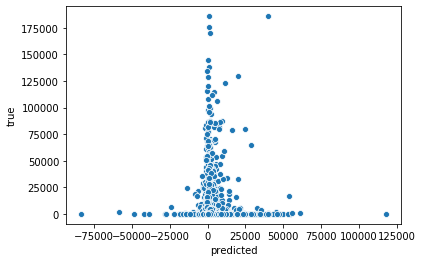

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df2['title'], df2['ups'], test_size=0.2, random_state=46)

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression(copy_X=True)),
])

text_clf.fit(X_train,y_train)

print(r2_score(y_train,text_clf.predict(X_train)))
print(r2_score(y_test,text_clf.predict(X_test)))

results = pd.DataFrame()
results["predicted"] = text_clf.predict(X_test)
results["true"] = list(y_test)
sns.scatterplot(data = results, x = "predicted", y = "true")


Doesn't look particularly useful... neither does using lasso...

0.019312400789961992
0.005437116554178001


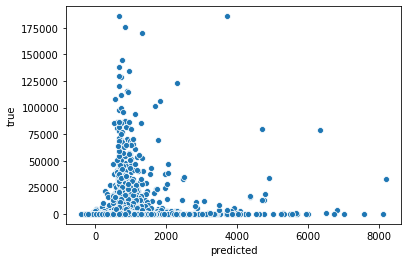

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df2['title'], df2['ups'], test_size=0.2, random_state=46)

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', sklearn.linear_model.Lasso()),
])

text_clf.fit(X_train,y_train)

print(r2_score(y_train,text_clf.predict(X_train)))
print(r2_score(y_test,text_clf.predict(X_test)))

results = pd.DataFrame()
results["predicted"] = text_clf.predict(X_test)
results["true"] = list(y_test)
sns.scatterplot(data = results, x = "predicted", y = "true")


# Can we predict if a post will be ignored?

In [12]:
def PopClassify(ups):
    if ups <100:
        return 0
    elif ups<100000:
        return 1
    else:
        return 2

#df2['popularity']=PopClassify(df2['ups'])

df2['popularity'] = df2['ups'].map(lambda score: PopClassify(score))

#df['ignored'] = df['ups'] <= 100 # What is a good cutoff for being ignored?
#df = wsb[ wsb['ups'] >= 20]
df2.head()

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups,total_awards_received,num_comments,num_crossposts,is_self,is_video,media_only,id,created_utc,selftext_html,author_fullname,popularity
4,4,I will remember,IpMedia,2020-01-01 23:30:47,removed,https://www.reddit.com/r/wallstreetbets/commen...,0.86,11,0,4,0,True,False,False,eipn7c,1.577921e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_bhcyy,0
7,7,New Years Challenge K Makeit or Breakit,DrSecret,2020-01-01 23:05:40,Alright WSBSo I recently came into about k due...,https://www.reddit.com/r/wallstreetbets/commen...,0.89,50,0,90,0,True,False,False,eipbbd,1.577920e+09,"<!-- SC_OFF --><div class=""md""><p>Alright WSB,...",t2_iap2a,0
10,10,How many of you tisms are doing the UPROTMF mix,phoq,2020-01-01 22:55:13,I saw an older thread on it curious who is sti...,https://www.reddit.com/r/wallstreetbets/commen...,0.94,27,0,35,0,True,False,False,eip6af,1.577919e+09,"<!-- SC_OFF --><div class=""md""><p>I saw an old...",t2_15h0dv,0
13,13,Exclusive Airbus beats goal with jet deliveri...,None,2020-01-01 22:19:13,deleted,https://www.reddit.com/r/wallstreetbets/commen...,0.94,13,0,7,0,True,False,False,eioqkv,1.577917e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,0
22,22,Day Trading how I lost it all,jeweledsky,2020-01-01 21:37:46,removed,https://www.reddit.com/r/wallstreetbets/commen...,0.96,1899,6,575,0,True,False,False,eio7dn,1.577915e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_2ohlnoqy,1


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df2['title'], df2['popularity'], test_size=0.2, random_state=46)

In [14]:
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [15]:
p=text_clf.predict(X_train)
print(np.where(p==1))
print(np.where(p==2))

(array([    65,     78,     99, ..., 116695, 116713, 116730], dtype=int64),)
(array([], dtype=int64),)


In [16]:
np.mean(p==y_train)

0.7372604100649184

In [17]:
p2=text_clf.predict(X_test)
np.mean(p2==y_test)

0.7155287588640334

In [18]:
#what if we just predict 0 all the time?
print(np.mean(y_train==0))
print(np.mean(y_test==0))

0.7193350576386153
0.7167962728238155


In [19]:
def PopClassifyn(ups,n):
    if ups <n:
        return 0
    else:
        return 1

In [20]:
#the above shows that the 0 category is too big. maybe cut it down to 50? Also throw out the top category



df2['popularity'] = df2['ups'].map(lambda score: PopClassifyn(score,50))

X_train, X_test, y_train, y_test = train_test_split(df2['title'], df2['popularity'], test_size=0.2, random_state=46)

In [21]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
print("accuracy on training data:")
p=text_clf.predict(X_train)
print(np.mean(p==y_train))
print(np.mean(y_train==0))
print("accuracy on testing data:")
print(np.mean(text_clf.predict(X_test)==y_test))
print(np.mean(y_test==0))

accuracy on training data:
0.6819170620578613
0.5839571093335161
accuracy on testing data:
0.597478674934055
0.5830906786338255


In [23]:
#slight improvement on the testing data, but lost on the training data...
#what about something more extreme? Let's keep all the posts with a score of 1. Let's try to predict ups>1
df3og=wsb.loc[(wsb.num_comments<=10000) & ~(wsb["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False))]

In [24]:
df3=RegexCols(df3og,['title', 'author', 'selftext'])

In [25]:
df3['popularity'] = df3['ups'].map(lambda score: PopClassifyn(score,2))

X_train, X_test, y_train, y_test = train_test_split(df3['title'], df3['popularity'], test_size=0.2, random_state=46,stratify=df3['popularity'])

In [26]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [27]:
print("accuracy on training data:")
p=text_clf.predict(X_train)
print(np.mean(p==y_train))
print(np.mean(y_train==0))
print("accuracy on testing data:")
print(np.mean(text_clf.predict(X_test)==y_test))
print(np.mean(y_test==0))

accuracy on training data:
0.7778754969417438
0.7723380039556363
accuracy on testing data:
0.7715679681002201
0.7723360141989041


In [28]:
#nothing!! what if we try using the selftext?
#back to df
df4og=wsb.loc[(wsb.is_self==True) & (wsb.num_comments<=10000) & ~(wsb["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False))]

df4=RegexCols(df4og,['title', 'author', 'selftext'])

df4['popularity'] = df4['ups'].map(lambda score: PopClassifyn(score,2))

X_train, X_test, y_train, y_test = train_test_split(df4['selftext'], df4['popularity'], test_size=0.2, random_state=46,stratify=df4['popularity'])

In [29]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [30]:
print("accuracy on training data:")
p=text_clf.predict(X_train)
print(np.mean(p==y_train))
print(np.mean(y_train==0))
print("accuracy on testing data:")
print(np.mean(text_clf.predict(X_test)==y_test))
print(np.mean(y_test==0))

accuracy on training data:
0.8448670002451768
0.7857120658040588
accuracy on testing data:
0.8437849634653369
0.7857093525974833


In [31]:
#okay, this is not too bad!
#other ways to measure how well this is doing?
#let's try the ROC AUC score
from sklearn.metrics import roc_curve

#text_clf.predict_proba(X_train)[:,1]
probs=text_clf.predict_proba(X_train)[:,1]

roc_curve(y_train,probs)

(array([0.        , 0.        , 0.        , ..., 0.02912557, 0.99888807,
        1.        ]),
 array([0.        , 0.00178874, 0.00216743, ..., 0.43720087, 0.99952462,
        1.        ]),
 array([2.        , 1.        , 1.        , ..., 0.10091671, 0.0498227 ,
        0.02419267]))

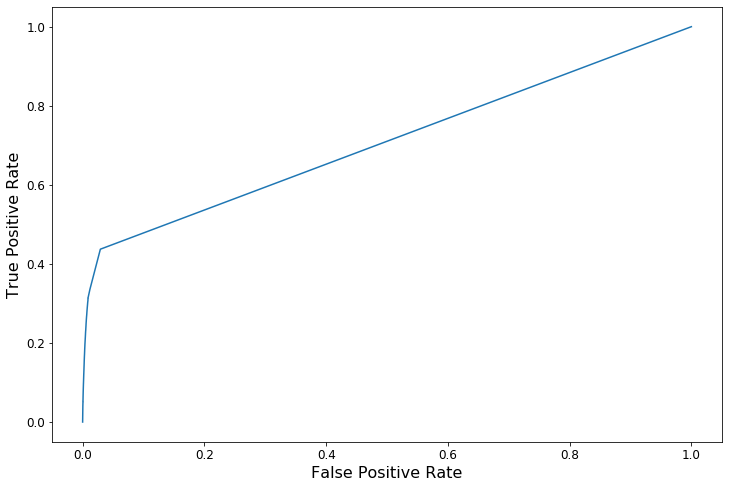

In [32]:
fpr,tpr,cutoffs = roc_curve(y_train,probs)
plt.figure(figsize=(12,8))

plt.plot(fpr,tpr)

plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,probs)

0.7071618300904127

In [39]:
#now let's try logistic regression rather than naive Bayes?
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     #('standardscaler', StandardScaler()),
                     ('clf', LogisticRegression(max_iter=1000)),
])

text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [44]:
print("accuracy on training data:")
p=text_clf.predict(X_train)
#print(np.mean(p==y_train))
print(accuracy_score(y_train,p))
print(np.mean(y_train==0))
print("accuracy on testing data:")
print(np.mean(text_clf.predict(X_test)==y_test))
print(np.mean(y_test==0))

accuracy on training data:
0.8566113119718772
0.8566113119718772
0.7857120658040588
accuracy on testing data:
0.8554359987292292
0.7857093525974833


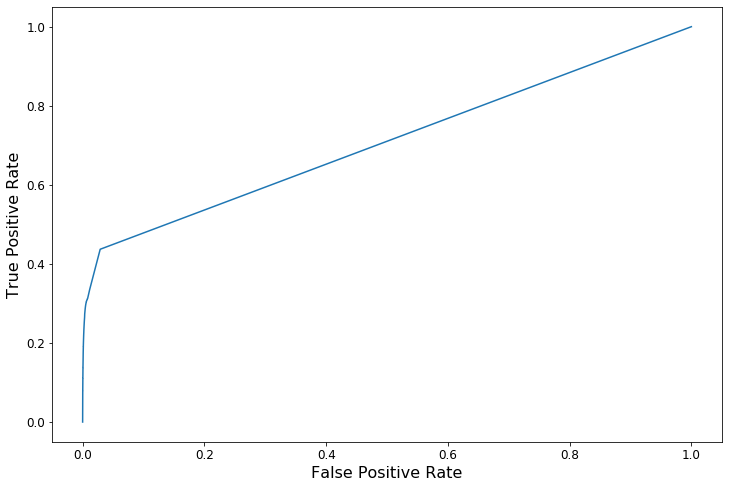

0.7077692677604395


In [40]:
#added later, for ROC curve and AUC score
probs=text_clf.predict_proba(X_train)[:,1]
fpr,tpr,cutoffs = roc_curve(y_train,probs)
plt.figure(figsize=(12,8))

plt.plot(fpr,tpr)

plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print(roc_auc_score(y_train,probs))

In [63]:
from sklearn.model_selection import cross_validate as cv
from sklearn.metrics import SCORERS as sc
from sklearn.metrics import make_scorer as ms
from sklearn.metrics import balanced_accuracy_score as bas

In [64]:
scorer_dict={
    'accuracy_scorer' : ms(accuracy_score),
    'auc_scorer' : ms(roc_auc_score),
    'bas_scorer' : ms(bas)
}




In [65]:
#scores = cross_validate(lasso, X, y, cv=3,
#...                         scoring=('r2', 'neg_mean_squared_error'),
#...                         return_train_score=True)

#X_train, X_test, y_train, y_test = train_test_split(df4['selftext'], df4['popularity'], test_size=0.2, random_state=46,stratify=df4['popularity'])

scores=cv(text_clf,df4['selftext'],df4['popularity'],cv=5,scoring=scorer_dict, return_train_score=True)

In [66]:
print(scores)

{'fit_time': array([40.94248843, 38.55260706, 52.81538129, 53.88970828, 45.90364528]), 'score_time': array([3.83659148, 3.69096971, 1.59402537, 1.73765063, 2.72420716]), 'test_accuracy_scorer': array([0.84263851, 0.88653535, 0.86513944, 0.83763027, 0.82727066]), 'train_accuracy_scorer': array([0.85876956, 0.8485412 , 0.85103095, 0.86105754, 0.86371304]), 'test_auc_scorer': array([0.75561674, 0.78339892, 0.68621156, 0.63678264, 0.61136783]), 'train_auc_scorer': array([0.69011388, 0.68260579, 0.6941842 , 0.72016217, 0.72657212]), 'test_bas_scorer': array([0.75561674, 0.78339892, 0.68621156, 0.63678264, 0.61136783]), 'train_bas_scorer': array([0.69011388, 0.68260579, 0.6941842 , 0.72016217, 0.72657212])}


In [67]:
print(np.mean(scores['test_accuracy_scorer']))
print(np.mean(scores['test_bas_scorer']))
print(np.mean(scores['test_auc_scorer']))

0.8518428455611801
0.6946755403441747
0.6946755403441747


In [36]:
#this is very slightly better than the other one. Might be even better if we can scale the data

In [37]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('standardscaler', StandardScaler(with_mean=False)),
                     ('clf', LogisticRegression(max_iter=10000)),
])

text_clf.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
print("accuracy on training data:")
p=text_clf.predict(X_train)
print(np.mean(p==y_train))
print(np.mean(y_train==0))
print("accuracy on testing data:")
print(np.mean(text_clf.predict(X_test)==y_test))
print(np.mean(y_test==0))

In [ ]:
#scaling somehow made it worse on the testing data??

# Can we cluster similar posts?

In [ ]:
df3.sort_values(by="ups")